In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.pylabtools import figsize
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score

Load Dataset and Read Dataset

In [36]:
df = pd.read_csv("online payment fraud data.csv")
print(df.shape)
print(df.head())
df.info()

(6362620, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig   
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36  \
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data column

In [37]:
#check whether there are null data
print(df.isnull().sum())

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64


In [38]:
#drop irrelevant columns
df.drop(columns=["nameOrig", "nameDest"], inplace=True)

In [39]:
#check class distribution of target feature 'isFraud'
df["isFraud"].value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

Explorative Data Analysis

In [40]:
df.describe().T
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 9 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   oldbalanceOrg   float64
 4   newbalanceOrig  float64
 5   oldbalanceDest  float64
 6   newbalanceDest  float64
 7   isFraud         int64  
 8   isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(1)
memory usage: 436.9+ MB


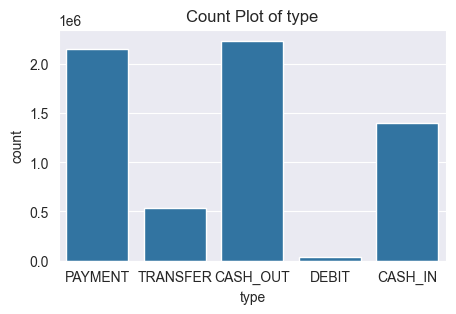

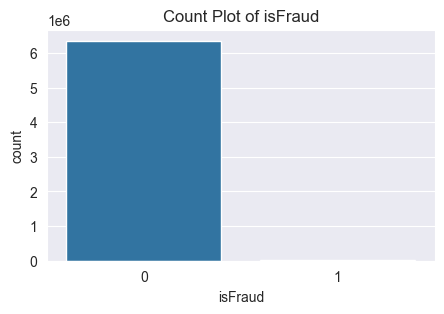

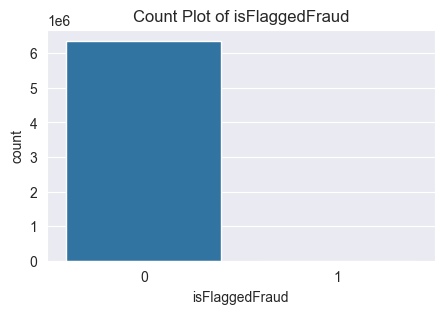

In [41]:
#create diagrams to visualise features
#create count plot for "type", "isFraud", "isFlaggedFraud"
columns = ["type", "isFraud", "isFlaggedFraud"]

for col in columns:
  plt.figure(figsize=(5, 3))
  sns.countplot(x=df[col])
  plt.title(f"Count Plot of {col}")
  plt.show()

In [42]:
#create histogramm for "step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"
def make_histogram(df, column):

  plt.figure(figsize=(5, 3))
  sns.histplot(df[column], kde=True)
  plt.title(f"Distribution of {column}")

  col_mean = df[column].mean()
  col_median = df[column].median()

  plt.axvline(col_mean, color="red", linestyle="--", label="Mean")
  plt.axvline(col_median, color="green", linestyle="-", label="Median")

  plt.legend(loc='upper right')
  plt.show()

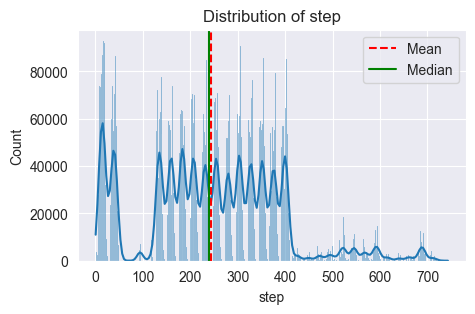

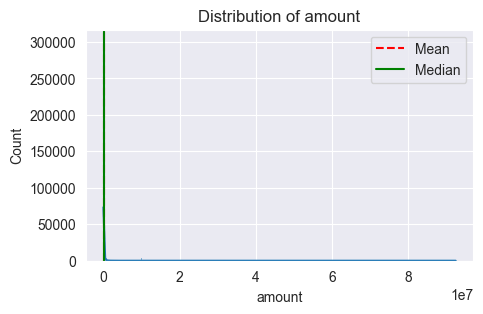

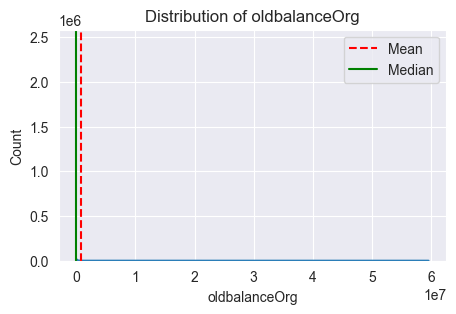

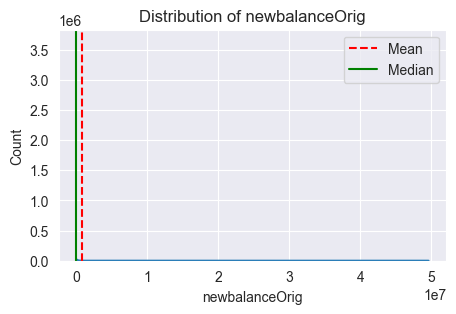

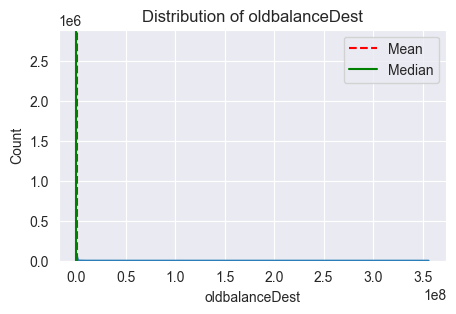

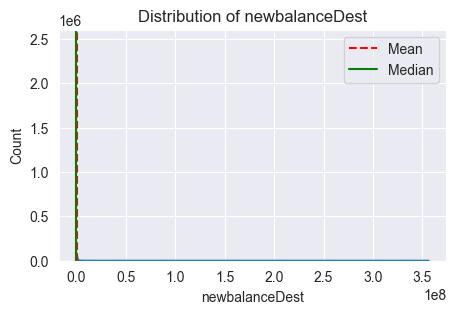

In [43]:
columns = ["step", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
for col in columns:
  make_histogram(df, col)

Data Preprocessing: Encoding

In [44]:
#one hot encoding of categorical feature "type"
df = pd.get_dummies(df, columns=["type"], dtype=int)
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,type_CASH_IN,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,0,1,0


Log Transformation

In [45]:
# Apply log transformation to heavily skewed columns
for col in ["amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]:
    # Add 1 to handle zeros as log(0) is undefined
    df[f"{col}_log"] = np.log1p(df[col])

Split Training and Test Data

In [46]:
X = df.drop(columns=["isFraud"])
y = df["isFraud"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.1, random_state=30)

Standardisation

In [47]:
sc = StandardScaler()
X_train_scaled = pd.DataFrame(sc.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(sc.transform(X_test), columns=X_test.columns)

In [48]:
smote = SMOTE(sampling_strategy=0.1, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

Model Training

In [50]:
models = {
    "Logistic Regression": LogisticRegression(random_state=33, max_iter=1000),
    "Random Forest": RandomForestClassifier(random_state=33),
    "XGBoost": XGBClassifier(random_state=33)
}

In [51]:
cv_scores = {}

# perform 5-fold cross validation for each model
for model_name, model in models.items():
  scores = cross_val_score(model, X_train_smote, y_train_smote, cv=5, scoring="f1")
  cv_scores[model_name] = scores
  print(f"{model_name} f1 score: {np.mean(scores)}")
  print("------")

  cv_scores

Logistic Regression f1 score: 0.9676332040095014
------
Random Forest f1 score: 0.9966720970082523
------
XGBoost f1 score: 0.9960010400679995
------


In [52]:
#train random forest model with entire training data as it has the highest f1 score
randomForest = RandomForestClassifier(random_state=33)
randomForest.fit(X_train_smote, y_train_smote)

RandomForestClassifier(random_state=33)

Model Evaluation

In [53]:
y_test_predict = randomForest.predict(X_test_scaled)

print("Confusion Matrix:\n", confusion_matrix(y_test, y_test_predict))
print("Classification Report:\n", classification_report(y_test, y_test_predict))
print("F1 Score:", f1_score(y_test, y_test_predict))

Confusion Matrix:
 [[5716005    3004]
 [    779    6570]]
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00   5719009
           1       0.69      0.89      0.78      7349

    accuracy                           1.00   5726358
   macro avg       0.84      0.95      0.89   5726358
weighted avg       1.00      1.00      1.00   5726358

F1 Score: 0.776458074809431
